In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
from scipy import stats
%matplotlib inline

In [2]:
hdtrain = pd.read_csv("./data/train.csv")
hdtest = pd.read_csv("./data/test.csv")

In [3]:
hdtrain.drop(hdtrain[(hdtrain['GrLivArea']>4000)&(hdtrain['SalePrice']<210000)].index,inplace=True)
#hdtrain.drop(hdtrain[[(hdtrain['OverallQual']<5)&(hdtrain['SalePrice']>200000)]])
hdtrain.drop(hdtrain[(hdtrain['YearBuilt']<1900)&(hdtrain['SalePrice']>390000)].index,inplace=True)
hdtrain.drop(hdtrain[(hdtrain['TotalBsmtSF']>6000)&(hdtrain['SalePrice']<200000)].index,inplace=True)
hdtrain.reset_index(drop=True, inplace=True)
hdtrain['SalePrice']=np.log1p(hdtrain["SalePrice"])

In [4]:
hdtotal = pd.concat([hdtrain,hdtest],ignore_index=True,sort=False)

normalization fit
=================

Handleing miss values

In [5]:
cols = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols:
    hdtotal[col].fillna("None", inplace=True)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea'):
    hdtotal[col] = hdtotal[col].fillna(0)
hdtotal["MSZoning"] = hdtotal.groupby("MSSubClass")["MSZoning"].transform(lambda x: x.fillna(x.mode()[0]))
hdtotal['KitchenQual']=hdtotal['KitchenQual'].fillna(hdtotal['KitchenQual'].mode()[0])
hdtotal['Exterior1st']=hdtotal['Exterior1st'].fillna(hdtotal['Exterior1st'].mode()[0])
hdtotal['Exterior2nd']=hdtotal['Exterior2nd'].fillna(hdtotal['Exterior2nd'].mode()[0])
hdtotal['SaleType']=hdtotal['SaleType'].fillna(hdtotal['SaleType'].mode()[0])
hdtotal['Utilities']=hdtotal['Utilities'].fillna(hdtotal['Utilities'].mode()[0])
hdtotal["Functional"] = hdtotal["Functional"].fillna("Typ")
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    hdtotal[col] = hdtotal[col].fillna(0)

In [6]:
x = hdtotal.loc[hdtotal["LotFrontage"].notnull(), "LotArea"]
y = hdtotal.loc[hdtotal["LotFrontage"].notnull(), "LotFrontage"]
t = (x <= 25000) & (y <= 150)
p = np.polyfit(x[t], y[t], 1)
hdtotal.loc[hdtotal['LotFrontage'].isnull(), 'LotFrontage'] = np.polyval(p, hdtotal.loc[hdtotal['LotFrontage'].isnull(), 'LotArea'])

In [7]:
hdtotal['TotalSF']=hdtotal['TotalBsmtSF']+hdtotal['1stFlrSF']+hdtotal['2ndFlrSF']
hdtotal['HasWoodDeck'] = (hdtotal['WoodDeckSF'] == 0) * 1
hdtotal['HasOpenPorch'] = (hdtotal['OpenPorchSF'] == 0) * 1
hdtotal['HasEnclosedPorch'] = (hdtotal['EnclosedPorch'] == 0) * 1
hdtotal['Has3SsnPorch'] = (hdtotal['3SsnPorch'] == 0) * 1
hdtotal['HScreenPorch'] = (hdtotal['ScreenPorch'] == 0) * 1
hdtotal['YrsSinceRemod'] = hdtotal['YrSold'].astype(int) - hdtotal['YearRemodAdd'].astype(int)
hdtotal['TotalHomeQual'] = hdtotal['OverallQual'] + hdtotal['OverallCond']

Encoding * * * Encoding * * *

In [8]:
hdtotal=pd.get_dummies(hdtotal)

In [10]:
print(hdtotal.shape)

(2916, 414)


In [11]:
from scipy.stats import skew

numerics = hdtotal.dtypes[hdtotal.dtypes != "object"].index

skewefs = hdtotal[numerics].apply(lambda x: skew(x.dropna())) #compute skewness
skewefs = skewefs[skewefs > 0.75]
skewefs = skewefs.index

hdtotal[skewefs] = np.log1p(hdtotal[skewefs])

In [12]:
train_index=hdtrain.index
test_index=list(set(hdtotal.index).difference(set(hdtrain.index)))

Start test
============

In [31]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso,  BayesianRidge, LassoLarsIC,RidgeCV,  LassoCV, LassoLarsCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import lightgbm as lgb

hdt_train = hdtotal.iloc[train_index]

y = hdt_train.SalePrice
X = hdt_train.drop(['SalePrice'], axis=1).select_dtypes(exclude=['object'])

learning_rate = [0.001,0.01,0.05,0.1,0.2] 
gamma = [1, 0.1, 0.01, 0.001]
param_grid = dict(learning_rate = learning_rate,gamma = gamma)
 
train_X, test_X, train_y, test_y = train_test_split(X.values, y.values, test_size=0.25)

In [221]:
xgbmodel1=XGBRegressor(n_estimators=3000, learning_rate=0.05, gamma=0.001)
xgbmodel1.fit(train_X,train_y,eval_set=[(test_X, test_y)],verbose=600)

[21:36:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10.9746
[600]	validation_0-rmse:0.117668
[1200]	validation_0-rmse:0.118461
[1800]	validation_0-rmse:0.118381
[2400]	validation_0-rmse:0.118381
[2999]	validation_0-rmse:0.118381


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [33]:
xgbmodel2=XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
xgbmodel2.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1.7817, missing=None,
             n_estimators=2200, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, seed=None, silent=1, subsample=0.5213,
             verbosity=1)

In [34]:
hdt_test = hdtotal.iloc[test_index]
hdt_test = hdt_test.drop(['SalePrice'], axis=1).select_dtypes(exclude=['object'])

In [224]:
prediction = xgbmodel1.predict(hdt_test.values)

In [223]:
prediction = xgbmodel2.predict(hdt_test)

In [225]:
predictions=[]
for pre in prediction:
    predictions.append(np.expm1(pre))

In [37]:
save = pd.DataFrame({
    'Id' : hdtest.Id,
    'SalePrice' : predictions
})

In [19]:
alphas = [0.000542555]
l1ratio = [0.1, 0.3,0.5, 0.9, 0.95, 0.99, 1]

ENet = ElasticNetCV(cv=5, max_iter=1e7, alphas=alphas,  l1_ratio=l1ratio)

In [20]:
lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005,0.0003,0.0002, 5e-4],max_iter=2000)
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


Considerable Lasso
------------------

In [30]:
lasso.fit(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.4768770894864955, tolerance: 0.015370589434091432
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3898185236222407, tolerance: 0.015014236805946324
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

LassoCV(alphas=[1, 0.1, 0.001, 0.0005, 0.0003, 0.0002, 0.0005], copy_X=True,
        cv='warn', eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100,
        n_jobs=None, normalize=False, positive=False, precompute='auto',
        random_state=None, selection='cyclic', tol=0.0001, verbose=False)

In [52]:
coef = pd.Series(lasso.coef_, index = X.columns)   

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

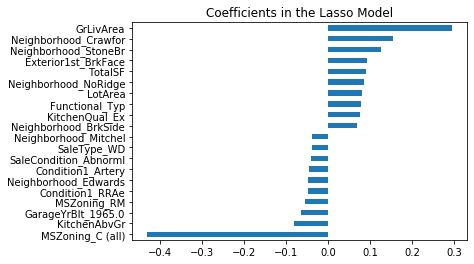

In [40]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [37]:
print("Lasso kept ",sum(coef != 0), "important features and dropped the other ", sum(coef == 0)," features")

Lasso kept  131 important features and dropped the other  282  features


In [57]:
unimfs=coef[coef==0].index.tolist()

In [63]:
for col in unimfs:
    hdtotal=hdtotal.drop(col,axis=1)

In [76]:
model_lgb.fit(X.values,y)
lprediction = model_lgb.predict(hdt_test.values)

In [77]:
lpredictions=[]
for pre in lprediction:
    lpredictions.append(np.expm1(pre))

In [25]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   
    

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [298]:
avm = AveragingModels(models = (ENet, GBoost, lasso, xgbmodel2, model_lgb))
avm.fit(X.values, y)

D:\Anaconda\envs\TensorCat\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.485065531873642, tolerance: 0.023168831112826953
  positive)
D:\Anaconda\envs\TensorCat\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Anaconda\envs\TensorCat\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


array([11.73254914, 11.96216592, 12.12723827, ..., 12.0182367 ,
       11.67217533, 12.28254246])

In [299]:
pav=avm.predict(hdt_test.values)

In [40]:
save = pd.DataFrame({
    'Id' : hdtest.Id,
    'SalePrice' : pred
})

In [82]:
sam = StackingAveragedModels(base_models = (ENet, GBoost, KRR, lasso),
                                                 meta_model = xgbmodel2)
sam.fit(X.values,y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.6373104595270425, tolerance: 0.018266153442351836
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.408588405500536, tolerance: 0.0185

StackingAveragedModels(base_models=(ElasticNetCV(alphas=[0.000542555],
                                                 copy_X=True, cv=5, eps=0.001,
                                                 fit_intercept=True,
                                                 l1_ratio=[0.1, 0.3, 0.5, 0.9,
                                                           0.95, 0.99, 1],
                                                 max_iter=10000000.0,
                                                 n_alphas=100, n_jobs=None,
                                                 normalize=False,
                                                 positive=False,
                                                 precompute='auto',
                                                 random_state=None,
                                                 selection='cyclic', tol=0.0001,
                                                 verbose=0),
                                    GradientBoostingRegressor(alpha=0.9,

In [83]:
spred=np.expm1(sam.predict(hdt_test.values))

In [87]:
ensemble = pd.DataFrame(spred)*0.70 + pd.DataFrame(predictions)*0.15 + pd.DataFrame(lpredictions)*0.15

In [85]:
save = pd.DataFrame({
    'Id' : hdtest.Id,
    'SalePrice' : ensemble.values[:,0]
})

In [15]:
def overfit_reducer(df):
    #This function takes in a dataframe and returns a list of features that are overfitted.
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.94:
            overfit.append(i)
    overfit = list(overfit)
    return overfit

In [30]:
overfitted_features = overfit_reducer(hdtotal)

hdtotal = hdtotal.drop(overfitted_features, axis=1)

In [90]:
from sklearn.ensemble import VotingRegressor

vote_mod = VotingRegressor([('GB',GBoost),('Ridge', KRR), ('Lasso', lasso), ('Elastic', ENet), ('XGBRegressor', xgbmodel2),('LightGBM',model_lgb)])
vote= vote_mod.fit(X,y)
vote_pred=vote.predict(hdt_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[09:42:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [91]:
vote_pred = np.expm1(vote_pred)
save = pd.DataFrame({
    'Id' : hdtest.Id,
    'SalePrice' : vote_pred
})

In [96]:
ensemble = pd.DataFrame(spred)*0.40+ pd.DataFrame(vote_pred)*0.15 + pd.DataFrame(predictions)*0.20 + pd.DataFrame(lpredictions)*0.25

In [97]:
save = pd.DataFrame({
    'Id' : hdtest.Id,
    'SalePrice' : ensemble.values[:,0]
})

In [ ]:
from mlxtend.regressor import StackingRegressor


streg = StackingRegressor(regressors=[ENet,KRR, lasso, vote_mod], 
                           meta_regressor=xgb, use_features_in_secondary=True
                          )

stack_mod=streg.fit(X,y.ravel())

In [110]:
save.to_csv('stackedD.csv', index=False)

In [46]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.svm import SVR

In [47]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

In [48]:
ridgep = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lassop = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnetp = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svrp = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))
gbrp = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)

In [49]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [50]:
lightgbm = lgb.LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [51]:
stack_gen = StackingCVRegressor(regressors=(ridgep, lassop, elasticnetp, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [52]:
print('elasticnet')
elastic_model_full_data = elasticnetp.fit(X, y)

print('Lasso')
lasso_model_full_data = lassop.fit(X, y)

print('Ridge') 
ridge_model_full_data = ridgep.fit(X, y)

print('Svr')
#svr_model_full_data = svrp.fit(X, y)

# print('GradientBoosting')




elasticnet
Lasso
Ridge
Svr


In [138]:
gbr_model_full_data = gbrp.fit(X, y)

In [53]:
svr_model_full_data = svrp.fit(X, y)

In [54]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)
print("stacking")
stack_gen_data=stack_gen.fit(X,y)

xgboost


D:\Anaconda\envs\TensorCat\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Anaconda\envs\TensorCat\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


lightgbm
stacking


In [56]:
edt=elastic_model_full_data.predict(hdt_test)
ldt=lasso_model_full_data.predict(hdt_test)
rdt=ridge_model_full_data.predict(hdt_test)

xdt=xgb_model_full_data.predict(hdt_test)
lgdt=lgb_model_full_data.predict(hdt_test)
sdt=stack_gen_data.predict(hdt_test.values)
svdt=svr_model_full_data.predict(hdt_test)

In [139]:
gdt=gbr_model_full_data.predict(hdt_test)

In [228]:
type(sdt)

numpy.ndarray

In [477]:
avmts=((0.0 * edt) + \
            (0.0 * ldt) + \
            (0.05 * rdt) + \
            (0.30 * svdt) + \
             (0.11 * gdt) + \
            (0.0 * xdt) + \
            (0.25 * lgdt) + \
            (0.19 * sdt)+\
            (0.10 * np.array(pav)))

In [478]:
print(len(avmts))

1459


In [479]:
est=avmts
est=np.expm1(est)

In [480]:
save = pd.DataFrame({
    'Id' : hdtest.Id,
    'SalePrice' : est
})

In [481]:
verify=pd.read_csv('y_true.csv')
from sklearn.metrics import mean_squared_error
vcopy=verify.copy()
scopy=save.copy()
vcopy['SalePrice']=vcopy['SalePrice'].apply(np.log1p)
scopy['SalePrice']=scopy['SalePrice'].apply(np.log1p)
print(mean_squared_error(vcopy,scopy))

0.007212282826731618


0.007501845346158475=11889

In [382]:
save.to_csv('reduceoverfitting5.csv',index=False)

In [446]:
save.to_csv('reduceof9.csv',index=False)

In [ ]:
of3=0.007334
of4=0.00726
of6=7259
of5=7255
of7=7241
of8=7220
of9=7205